In [26]:
import cv2
import os
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import shuffle
import glob
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input,Conv2D, Dense, Flatten ,Dropout ,MaxPooling2D,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras import layers, Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from PIL import Image

import tensorflow as tf
from tensorflow import keras
import warnings
warnings.filterwarnings('ignore')

In [27]:
path_No = '/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/*'
path_Yes = '/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes/*'

tumor = []
no_tumor = []
random_state = 42

for file in glob.iglob(path_Yes):
    img = cv2.imread(file)      
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)        
    img = cv2.resize(img, (128, 128)) 
    tumor.append((img, 1))  

for file in glob.iglob(path_No):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))
    no_tumor.append((img, 0))  

all_data = tumor + no_tumor


data = np.array([item[0] for item in all_data])
labels = np.array([item[1] for item in all_data])

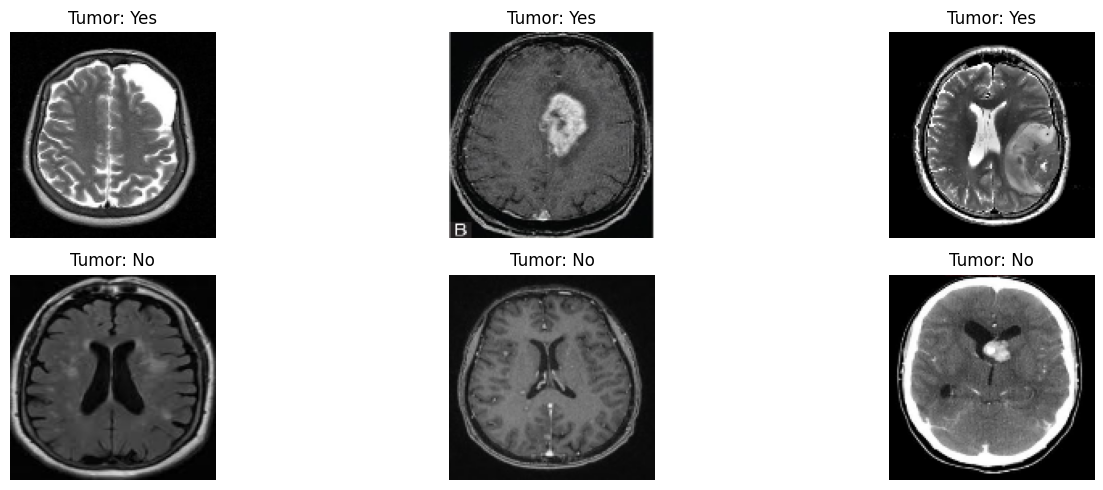

In [28]:
plt.figure(figsize=(15, 5))

for i in range(3):
    plt.subplot(2, 3, i+1)
    plt.imshow(tumor[i][0])  
    plt.title("Tumor: Yes")  
    plt.axis('off')

for i in range(3):
    plt.subplot(2, 3, i+4)
    plt.imshow(no_tumor[i][0])  
    plt.title("Tumor: No")  
    plt.axis('off')

plt.tight_layout()
plt.show()

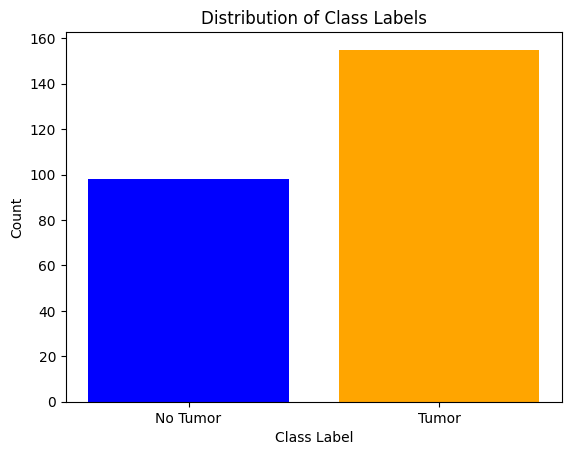

In [29]:
unique_labels, label_counts = np.unique(labels, return_counts=True)

plt.bar(unique_labels, label_counts, color=['blue', 'orange'])
plt.xticks(unique_labels, ['No Tumor', 'Tumor'])
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Distribution of Class Labels')
plt.show()


In [30]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.20, random_state=42)

In [31]:
# range [0, 1]
x_train= x_train /255.0
x_test = x_test / 255.0


In [32]:
print("Minimum value of the scaled data:", x_train.min())
print("Maximum value of the scaled data:",  x_train.max())

Minimum value of the scaled data: 0.0
Maximum value of the scaled data: 1.0


In [46]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.8))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))



In [47]:
model.compile(optimizer='Adam',loss='binary_crossentropy', metrics=['accuracy'])

In [48]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [50]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.0:
            print("\nReached 99% accuracy so cancelling training!")
            self.model.stop_training = True
            
back = myCallback() 

In [53]:
history = model.fit(x_train, 
                    y_train,
                    epochs=20,
                    batch_size=32,
                    validation_split=0.2
                   )

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 321ms/step - accuracy: 0.7950 - loss: 0.4913 - val_accuracy: 0.7317 - val_loss: 0.4772
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 337ms/step - accuracy: 0.8031 - loss: 0.4288 - val_accuracy: 0.7805 - val_loss: 0.4516
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 333ms/step - accuracy: 0.7887 - loss: 0.5128 - val_accuracy: 0.8049 - val_loss: 0.4298
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 316ms/step - accuracy: 0.8373 - loss: 0.3723 - val_accuracy: 0.8049 - val_loss: 0.4414
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 329ms/step - accuracy: 0.8113 - loss: 0.4008 - val_accuracy: 0.8049 - val_loss: 0.4284
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 340ms/step - accuracy: 0.8004 - loss: 0.4949 - val_accuracy: 0.8049 - val_loss: 0.4549
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 322ms/step - accuracy: 0.8881 - loss: 0.3113 - val_accuracy: 0.7317 - val_loss: 0.4711
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 356ms/step - accuracy: 0.8115 - loss: 0.4215 - val_accuracy: 0.7073 - val_loss:

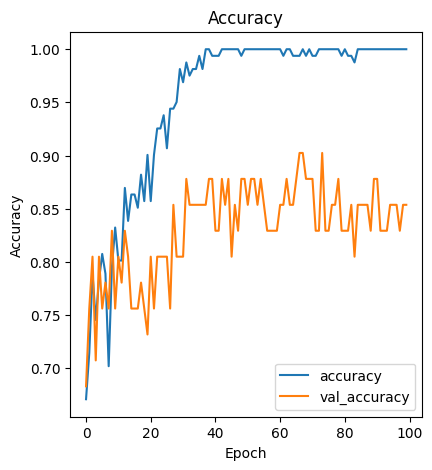

In [40]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

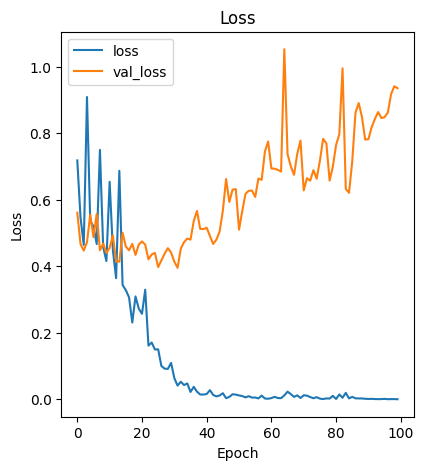

In [42]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss")
plt.show()

In [43]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9138 - loss: 1.4553
Test Loss: 1.4824013710021973
Test Accuracy: 0.9019607901573181
